# Quick notebook to convert rframe files 

Going from **hdf5** format (as extracted from bag files) to **cpkl** format (as obtained from the GUI)

In [536]:
import os
import h5py
import cPickle

import numpy as np

## load rframe from hdf5

In [537]:
# get path to data
root_path = '/media/sam/SamData/FlyDB'
fly_num = 22
side = 'left'

data_path = os.path.join(root_path, 'Fly%04d' %(fly_num))
fn = 'live_viewer_%s_rframe_fits.hdf5' %(side)

In [538]:
# load hdf5 file
rframe = dict()
grp_key = 'LogRefFrame'
# grp_key = 'ModelViewFrame'

with h5py.File(os.path.join(data_path, fn), 'r') as f:
    for key in f[grp_key].keys():
        print(key, ' = ', f[grp_key][key][()])
        rframe[key] = np.unique(f[grp_key][key][()])     

(u'A', ' = ', array([[-125.68180573,  -10.4302642 ,   15.40181465, -161.55766788],
       [-125.68180573,  -10.4302642 ,   15.40181465, -161.55766788]]))
(u'Ainv', ' = ', array([[-0.00789415,  0.00050965, -0.00075257, -0.00614115],
       [-0.00789415,  0.00050965, -0.00075257, -0.00614115]]))
(u'a1', ' = ', array([[-125.68180573,   15.40181465],
       [-125.68180573,   15.40181465]]))
(u'a2', ' = ', array([[ -10.4302642 , -161.55766788],
       [ -10.4302642 , -161.55766788]]))
(u'components', ' = ', array(['pr;tpd;nm;i1;iii3;i2;hg2;hg3;hg1;iii1;b1;b2;b3;iii24;hg4;bkg',
       'pr;tpd;nm;i1;iii3;i2;hg2;hg3;hg1;iii1;b1;b2;b3;iii24;hg4;bkg'],
      dtype='|S60'))
(u'p', ' = ', array([[248.57556067, 219.54194575],
       [248.57556067, 219.54194575]]))
(u'ros_tstamps', ' = ', array([1.67063541e+09, 1.67063565e+09]))


In [539]:
# check that we loaded stuff correctly
for k in rframe.keys():
    print('%s =' %(k), rframe[k])

(u'A =', array([-161.55766788, -125.68180573,  -10.4302642 ,   15.40181465]))
(u'Ainv =', array([-0.00789415, -0.00614115, -0.00075257,  0.00050965]))
(u'ros_tstamps =', array([1.67063541e+09, 1.67063565e+09]))
(u'a1 =', array([-125.68180573,   15.40181465]))
(u'p =', array([219.54194575, 248.57556067]))
(u'a2 =', array([-161.55766788,  -10.4302642 ]))
(u'components =', array(['pr;tpd;nm;i1;iii3;i2;hg2;hg3;hg1;iii1;b1;b2;b3;iii24;hg4;bkg'],
      dtype='|S60'))


In [540]:
# try to get A and Ainv to retain their shape
rframe['A'] = np.reshape(rframe['A'], (2,2))
rframe['Ainv'] = np.reshape(rframe['Ainv'], (2,2))

## deal with this transformation confusion

In [541]:
# get the array of points
# rframe['p'][1] = rframe['p'][1]print(M)
# rframe['a1'][1] = rframe['a1'][1]*-1
# rframe['a2'][1] = rframe['a2'][1]*-1

points = np.array([(rframe['p'][0]+rframe['a1'][0],rframe['p'][1]+rframe['a1'][1]),
                    (rframe['p'][0],rframe['p'][1]),
                    (rframe['p'][0]+rframe['a2'][0],rframe['p'][1]+rframe['a2'][1])])

print('points: ', points)

('points: ', array([[ 93.86014002, 263.97737531],
       [219.54194575, 248.57556067],
       [ 57.98427788, 238.14529647]]))


In [542]:
# # i think it's something like a 180 degree rotation. 
img_shape = np.array([270, 360])  # just going to cheat and hard-code in
import cv2
M = cv2.getRotationMatrix2D((img_shape[1]/2, img_shape[0]/2), 180,1)

points_flip = np.fliplr(points.copy())
points_homogeneous = np.hstack([points_flip, np.ones(shape=(points_flip.shape[0], 1))]).T
print(points_homogeneous.T)

transformed_points = M.dot(points_homogeneous).T
# print(transformed_points)
# transformed_points = points_flip 
transformed_points[:,1] = img_shape[0] - transformed_points[:,1]
print(transformed_points)

[[263.97737531  93.86014002   1.        ]
 [248.57556067 219.54194575   1.        ]
 [238.14529647  57.98427788   1.        ]]
[[ 96.02262469  93.86014002]
 [111.42443933 219.54194575]
 [121.85470353  57.98427788]]


In [543]:
# transformed_points = points.copy()
# transformed_points[:,0] = img_shape[1] - transformed_points[:,0]
# print(transformed_points)

In [544]:
# # create new rframe from transformed points
# rframe_new = rframe.copy()
# rframe_new['p'] = transformed_points[1,:2]
# rframe_new['a1'] = transformed_points[0,:2] - transformed_points[1,:2]
# rframe_new['a2'] = transformed_points[2,:2] - transformed_points[1,:2]

rframe_new = rframe.copy()
rframe_new['p'] = rframe_new['p']
rframe_new['a1'] = np.flip(rframe_new['a1'])
rframe_new['a2'] = np.flip(rframe_new['a2'])

A = np.vstack((rframe_new['a1'],rframe_new['a2'])).T
A_inv = np.linalg.inv(A)

rframe_new['A'] = A
rframe_new['Ainv'] = A_inv

In [545]:
# # try some noodling
# img_shape = np.array([270, 360])
# p = rframe['p'].copy()

# p_new = rframe['p'].copy()
# p_new[1] = img_shape[1] - p_new[1]
# p_new = np.flip(p_new)

# print('old p = ', p)
# print('new p =', p_new)

# a1_new = rframe['a1'].copy()
# a1_new[0] = -1*a1_new[0]
# # # a1_new[1] = img_shape[1] - a1_new[1]
# # a1_new = np.flip(a1_new)
# # print(rframe['a1'])
# print(a1_new)

# a2_new = rframe['a2'].copy()
# a2_new = np.flip(rframe['a2'])
# a2_new[0] = -1*a2_new[0]
# print(a2_new)


In [546]:
# rframe_new = rframe.copy()
# rframe_new['p'] = p_new
# rframe_new['a1'] = a1_new
# rframe_new['a2'] = a2_new

In [547]:
print('OLD:')
for key in rframe.keys():
    print('%s = '%(key), rframe[key])

OLD:
(u'A = ', array([[-161.55766788, -125.68180573],
       [ -10.4302642 ,   15.40181465]]))
(u'Ainv = ', array([[-0.00789415, -0.00614115],
       [-0.00075257,  0.00050965]]))
(u'ros_tstamps = ', array([1.67063541e+09, 1.67063565e+09]))
(u'a1 = ', array([-125.68180573,   15.40181465]))
(u'p = ', array([219.54194575, 248.57556067]))
(u'a2 = ', array([-161.55766788,  -10.4302642 ]))
(u'components = ', array(['pr;tpd;nm;i1;iii3;i2;hg2;hg3;hg1;iii1;b1;b2;b3;iii24;hg4;bkg'],
      dtype='|S60'))


In [548]:
print('NEW:')
for key in rframe_new.keys():
    print('%s = '%(key), rframe_new[key])

NEW:
(u'A = ', array([[  15.40181465,  -10.4302642 ],
       [-125.68180573, -161.55766788]]))
(u'a1 = ', array([  15.40181465, -125.68180573]))
(u'Ainv = ', array([[ 0.0425244 , -0.0027454 ],
       [-0.03308134, -0.00405399]]))
(u'a2 = ', array([ -10.4302642 , -161.55766788]))
(u'components = ', array(['pr;tpd;nm;i1;iii3;i2;hg2;hg3;hg1;iii1;b1;b2;b3;iii24;hg4;bkg'],
      dtype='|S60'))
(u'p = ', array([219.54194575, 248.57556067]))
(u'ros_tstamps = ', array([1.67063541e+09, 1.67063565e+09]))


In [549]:
# # get new transformation matrix as well
# A = np.vstack((rframe_new['a1'],rframe_new['a2'])).T
# A_inv = np.linalg.inv(A)
# rframe_new['A'] = 0.*A 
# rframe_new['Ainv'] = Ainv
# print(A)

(0, 360)

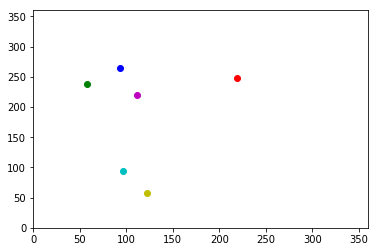

In [550]:
# quick graphical test
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
marker_list = ['bo', 'ro', 'go']
marker_list_new = ['co', 'mo', 'yo']


for ith in range(len(key_list)):
    ax.plot(points[ith][0], points[ith][1], marker_list[ith])
    ax.plot(transformed_points[ith][0], transformed_points[ith][1], marker_list_new[ith])
    
ax.set_xlim([0, img_shape[1]])
ax.set_ylim([0, img_shape[1]])

## save as cpickle file

In [551]:
## temp: just give it a manual answer
rframe_new = rframe.copy()
rframe_new['a1'] = np.array([113.57617785,  13.04314034])
rframe_new['a2'] = np.array([20.81125759, -181.0342006])
rframe_new['p'] = np.array([106.95791222, 227.10423465])

In [552]:
# save dict as pickle file
save_fn = 'ca_camera_%s_rframe_fits.cpkl' %(side)
A = np.vstack((rframe_new['a1'],rframe_new['a2'])).T
A_inv = np.linalg.inv(A)

rframe_new['A'] = A
rframe_new['Ainv'] = A_inv
with open(os.path.join(data_path, save_fn),'wb') as f:
    cPickle.dump(rframe_new, f)

In [553]:
"""
From manual adjustment:

('a1 =', array([121.57703567,  10.29115987]))
('A =', array([[ 121.57703567,   -2.68381323],
       [  10.29115987, -163.95834655]]))
('a2 =', array([  -2.68381323, -163.95834655]))
('A_inv =', array([[ 0.00823665, -0.00013482],
       [ 0.00051699, -0.00610757]]))
('p =', array([123.23231623, 225.14260015]))
"""

"\nFrom manual adjustment:\n\n('a1 =', array([121.57703567,  10.29115987]))\n('A =', array([[ 121.57703567,   -2.68381323],\n       [  10.29115987, -163.95834655]]))\n('a2 =', array([  -2.68381323, -163.95834655]))\n('A_inv =', array([[ 0.00823665, -0.00013482],\n       [ 0.00051699, -0.00610757]]))\n('p =', array([123.23231623, 225.14260015]))\n"

In [554]:
"""
From a second manual adjustment (printed by GUI)
('a1 =', array([112.61311877,   8.21935677]))
('A =', array([[ 112.61311877,    0.58701694],
       [   8.21935677, -181.0342006 ]]))
('a2 =', array([   0.58701694, -181.0342006 ]))
('A_inv =', array([[ 8.87785899e-03,  2.87871219e-05],
       [ 4.03a1074613e-04, -5.52251113e-03]]))
('p =', array([126.21909379, 230.72207233]))

"""

"\nFrom a second manual adjustment (printed by GUI)\n('a1 =', array([112.61311877,   8.21935677]))\n('A =', array([[ 112.61311877,    0.58701694],\n       [   8.21935677, -181.0342006 ]]))\n('a2 =', array([   0.58701694, -181.0342006 ]))\n('A_inv =', array([[ 8.87785899e-03,  2.87871219e-05],\n       [ 4.03a1074613e-04, -5.52251113e-03]]))\n('p =', array([126.21909379, 230.72207233]))\n\n"

In [555]:
"""
('a1 =', array([113.57617785,  13.04314034]))
('A =', array([[ 113.57617785,   20.81125759],
       [  13.04314034, -181.0342006 ]]))
('a2 =', array([  20.81125759, -181.0342006 ]))
('A_inv =', array([[ 0.00868994,  0.00099897],
       [ 0.00062609, -0.00545184]]))
('p =', array([106.95791222, 227.10423465]))
"""

"\n('a1 =', array([113.57617785,  13.04314034]))\n('A =', array([[ 113.57617785,   20.81125759],\n       [  13.04314034, -181.0342006 ]]))\n('a2 =', array([  20.81125759, -181.0342006 ]))\n('A_inv =', array([[ 0.00868994,  0.00099897],\n       [ 0.00062609, -0.00545184]]))\n('p =', array([106.95791222, 227.10423465]))\n"

## Scratch

In [556]:
# is there a way to learn anything from the affine transformation between what we expect and what we get?